In [1]:
%matplotlib ipympl 

import sys
sys.path.insert(1, '/user/scratch14_csa/jissa/NuGridPy')

import numpy as np
from matplotlib import pyplot as plt

from nugridpy import mesa as ms
from nugridpy import nugridse as nuse
from nugridpy import utils

import os
import sys
import contextlib
import pandas as pd

import h5py

from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable

from astropy import constants as const
from astropy import units as u

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

# important feature!
from multizone import mppnp_reader

In [1]:
#pip install iniabu

In [2]:
from iniabu import ini # default: Loedders 2009 #https://pypi.org/project/iniabu/
ini._unit = 'mass_fraction'

In [3]:
mesarun = ms.star_log("/data/nugrid/data/set1ext/set1.2/see_wind/M15.0Z2.0e-02/LOGS")
star = nuse.se("/data/nugrid/data/set1ext/set1.2/ppd_wind/M15.0Z2.0e-02/H5_out")
surf = nuse.se("/data/nugrid/data/set1ext/set1.2/ppd_wind/M15.0Z2.0e-02/H5_surf")

Using old star.logsa file ...
 reading ...100% 

Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.


In [4]:
star_age = mesarun.get('star_age')
model_number = mesarun.get('model_number')
Mdot = np.abs(mesarun.get('star_mdot'))
dt = np.power(10, mesarun.get('log_dt'))

dM = Mdot * dt
Mlost = np.cumsum(dM)

In [6]:
surface_elements_decayed = np.vstack(surf.get('elem_massf_decay'))
EMwind_decay = np.zeros(surface_elements_decayed.shape[1])
for i in range(surface_elements_decayed.shape[1]):

    EMwind_decay[i] = np.trapz(np.abs(Mdot) * surface_elements_decayed[:-2,i], star_age)

 reading ['elem_massf_decay']...100%

In [7]:
star.get_abundance_elem(21000)
decayed_elements_21000 = np.vstack(star.element_abundance_decayed)

 reading ['mass']...100%Using The following conditions:
	mass_range: 3.8433032128025213e-07 12.15340998801299
	cycle: 21000
 reading ['iso_massf']...100%WARNING:
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


In [8]:
star.get_abundance_elem(9200)
decayed_elements_9200 = np.vstack(star.element_abundance_decayed)
ri_mass_9200 = star.get(9200, "mass")

 reading ['mass']...100%Using The following conditions:
	mass_range: 3.8433534134926377e-07 12.15340998801299
	cycle: 9200
 reading ['iso_massf']...100%WARNING:
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
 reading ['mass']...100%

In [10]:
ri_mass_21000 = star.get(21000, "mass")

def getyields():
        
        
    def get_idx(thing, what):
        
        return np.argmin(np.abs(thing-what))

    eles = star.se.isos[1:-2] # assume no At ? in elemental_abunds... whatever it is there is a discrepancy between len(eles) and len(list(set(star.se.Z)))    
            
    delay, rapid = get_idx(ri_mass_21000, 1.61), get_idx(ri_mass_21000, 1.44)
        
        
    # this is only SN yields... I need wind yields too...
        
        
    delayMej = ri_mass_21000[-1] - ri_mass_21000[delay]
    rapidMej = ri_mass_21000[-1] - ri_mass_21000[rapid]
        
    delayedEM = np.zeros(len(eles))
    rapidEM = np.zeros(len(eles))
        
    for i in range(len(eles)):
        
        delayedEM[i] = np.trapz(decayed_elements_21000[delay:,i] , ri_mass_21000[delay:])

        rapidEM[i]   = np.trapz(decayed_elements_21000[rapid:,i] , ri_mass_21000[rapid:])
        
    return eles, delayedEM, rapidEM, delayMej, rapidMej
    
eles, delayedEM, rapidEM, delayMej, rapidMej = getyields()

 reading ['mass']...100%

In [5]:
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [6]:
def round_to_nearest(arr, step):
    '''Rounds the maximum and minimum of an array to the closest "step". 

    Parameters
    ----------
    arr: list or np.array
        The data to get the rounded maximum and minimum.

    step: float
        The value to round to.

    Returns
    -------
    floored_min: float
        The minimum rounded to the floor of the step
        (ie. if step == 10 and min is 3 then it rounds to 0).

    ceiled_max: float
         The maximum rounded to the ceiling of the step 
         (ie. if step == 10 and max is 8 then it rounds to 10).
    '''

    min_val = np.min(arr)
    max_val = np.max(arr)

    floored_min = np.floor(min_val / step) * step
    ceiled_max = np.ceil(max_val / step) * step

    return floored_min, ceiled_max    

In [7]:
def scale_size(value, minval, maxval, min_size=1, max_size=50, centre=0):

    abs_cent_value = np.abs(value - centre)
    
    normalize = np.max([np.abs(maxval-centre), np.abs(minval-centre)])
    
    normalized_value = abs_cent_value / normalize
    
    return normalized_value * (max_size - min_size) + min_size

In [8]:
def get_color(value, minFij, maxFij, cmap=plt.cm.jet, get='color'):
    '''Sets the colour bar scale.
    '''

    
    def set_scale():
        norm = mcolors.Normalize(vmin=minFij, vmax=maxFij)

        return norm

    norm = set_scale()
    
    if get == 'color':
        normalized_values = norm(value)

        rgba_colors = cmap(normalized_values)
        if type(rgba_colors) != type(np.array): rgba_colors = np.array(rgba_colors)
        rgba_colors[value < minFij, 3] = 0  # turn off if under minFij

        return rgba_colors
    
    elif get == 'map':
        return norm, cmap


In [9]:
def get_everything_you_need(mixing_case, sub_case="7.95E+03"):
    # the initial abundances for NOVA models are the Asplund et al. (2009) solar abundances 
    upper = "/data/niagara_project/projects/ocmerger_issa2025/RUNS/"
    if mixing_case != "GOSH": mppnp_test_dir=upper + f"{mixing_case}_RUNS/hif{sub_case}/H5_surf/"
    else: mppnp_test_dir=upper + f"{mixing_case}_RUNS/{sub_case}/H5_surf/"
    
    sol_ab="/data/niagara_project/projects/ocmerger_issa2025/CONDITIONS/iniab2.0E-02GN93.ppn"
    
    init_ab=sol_ab
    
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)

    # read in initial elemental abundances in the path init_ab
    utils.solar(init_ab,1.)
    init_abu=utils.solar_elem_abund
    n_init=len(init_abu)
    #print ("\nn_init =",n_init)

    # read in solar abundances in the path sol_ab
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)
    #print ("\nn_sol =",n_sol)
    
    # initial and solar abundances do not include Tc and Pm
    # here we include them with the abundances 1e-99
    
    n_el = n_sol + 2  # n_sol + the unstable Tc (Z=43) and Pm (Z=61)
    
    el_name=["  " for x in range(n_el)]
    
    z_el=np.linspace(0,0,n_el)
    
    el_name[0]='n'
    for i in range(n_el):
        z_el[i]=float(i)       #  Z=i in mppnp surf data output
        if (i>0):
            el_name[i]=utils.get_el_from_z(i)
    
    # el_abu_init = np.linspace(1e-99,1e-99,n_el)
    el_abu_sol = np.linspace(1e-99,1e-99,n_el)
    
    for i in range(n_el):  
        for k in range(n_sol):
            z_sol=k+1
            if float(z_sol)==z_el[i] and z_sol != 43 and z_sol != 61:  
    #             el_abu_init[i] = init_abu[k]
                el_abu_sol[i] = sol_abu[k]
    
    # print ("X_init =",el_abu_init[1],", X_init(Tc) =", el_abu_init[43],", X_init(Pm) =", el_abu_init[61])
    #print ("X_sol =",el_abu_sol[1],", X_sol(Tc) =", el_abu_sol[43],", X_sol(Pm) =", el_abu_sol[61])

    work_dir = mppnp_test_dir

    model = 11000
    
    mc = 0 
    h5_file = work_dir + "my_test_hif.0010001.surf.h5"
    
    #print("Zero variation case:", h5_file)
    with h5py.File(h5_file, 'r') as file:
        dset = file["/cycle"+str(model).zfill(10)+"/SE_DATASET"]
        el_abu_0 = dset['elem_massf_decay'][0]
        iso_abu_0 = dset['iso_massf_decay'][0]

    
        n_iso = len(iso_abu_0)
        iso_z=np.linspace(0,0,n_iso)
        iso_a=np.linspace(0,0,n_iso)
        iso_name=["  " for x in range(n_iso)]

        iso_name[0] = 'n'
        iso_name[1] = 'H'
        
        dseta = file["A"]
        dsetz = file["Z"]
        iso_a[:] = dseta[:]
        iso_z[:] = dsetz[:]

    
    isomers = ['ALm', 'KRm', 'CDm', 'LUm', 'TAm']
    start = n_iso - len(isomers)
    for isomer in isomers: 
        i = isomers.index(isomer)
        iso_name[start+i] = isomer
    
    for i in range(2,n_iso-len(isomers)):
        iz = int(iso_z[i])
        iso_name[i] = utils.get_el_from_z(int(iso_z[i]))
        
    iso_full_name = []
    for i in range(n_iso):
        iso_full_name.append(iso_name[i]+"-"+str(int(iso_a[i])))
    
    return el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_full_name

In [10]:
el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need("MLT")

This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


### Is there a way to choose the stuff in black to be my stuff and not the NuGrid stuff?
Naive approach:
$$
X_\mathrm{f} = X_{\mathrm{wind}} + \frac{1}{m_{\mathrm{ejecta}}}\Biggl( \int_{\mathrm{under~O-C}} X~ dm + \int_{\mathrm{O-C}} X\cdot \mathrm{ratio}~ dm + \int_{\mathrm{above~O-C}} X ~dm\Biggr)
$$

where $\mathrm{ratio} = \langle X_{\mathrm{Issa+25}} \rangle \div \langle X_{\mathrm{Ritter+18}} \rangle$

In [17]:
left = 1.5510275
right = 1.9983082

lidx = np.argmin(np.abs(ri_mass_9200 - left))
ridx = np.argmin(np.abs(ri_mass_9200 - right))
mOshell = ri_mass_9200[ridx] - ri_mass_9200[lidx]

In [18]:
def calculate_Xf(mixing_case, sub_case):
    
    el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need(mixing_case, sub_case)
    
    eles = star.se.isos[1:-2] # assume no At ? in elemental_abunds... whatever it is there is a discrepancy between len(eles) and len(list(set(star.se.Z)))
    
    def get_idx(thing, what):
        
        return np.argmin(np.abs(thing-what))
    
    
    def get_ratios():
        
        left = 1.5510275
        right = 1.9983082

        lidx = np.argmin(np.abs(ri_mass_9200 - left))
        ridx = np.argmin(np.abs(ri_mass_9200 - right))
        
        ratios = []
        
        for el in el_name[1:-1]:

            me_i = el_name.index(el)
            ri_i = eles.index(el)
            
            mOshell = ri_mass_9200[ridx] - ri_mass_9200[lidx]

            X_av_ri = np.trapz( decayed_elements_9200[lidx:ridx, ri_i], ri_mass_9200[lidx:ridx] ) / mOshell

            X_surf_me = el_abu_0[me_i]

            ratios.append(X_surf_me/X_av_ri)

        return ratios
    
    
    ratios = get_ratios()    
        
    #q, j,k,l = get_idx(ri_mass_21000,1.44), get_idx(ri_mass_21000,1.5510275), get_idx(ri_mass_21000,2.95), -1
    
    j, k, l = get_idx(ri_mass_21000,1.61), get_idx(ri_mass_21000,2.95), -1
    
    X_nugrid = []
    X_issa = []
    
    for el in el_name[1:-1]:
    
        ri_i = eles.index(el)
        
        ratio_idx = el_name[1:-1].index(el)
        ratio = ratios[ratio_idx]
        
        #X_av_under = np.trapz( decayed_elements_21000[q:j, ri_i] , ri_mass_21000[q:j])
        X_av_oc = np.trapz( decayed_elements_21000[j:k, ri_i] * ratio , ri_mass_21000[j:k])
        X_av_above = np.trapz( decayed_elements_21000[k:l, ri_i], ri_mass_21000[k:l])
        
        #X_issa.append( (X_av_under + X_av_oc + X_av_above) + EMwind_decay[1:-1][ri_i] )
        X_issa.append( (X_av_oc + X_av_above) + EMwind_decay[1:-1][ri_i] )
                
        X_nugrid.append( np.trapz( decayed_elements_21000[j:l, ri_i], ri_mass_21000[j:l] ) + EMwind_decay[1:-1][ri_i] )

    # renormalize such that np.sum(X) = 1
        
    X_nugrid = np.array(X_nugrid)
    
    #print(f"\nI have to renormalize X(NuGrid) because it sums to {round(np.sum(X_nugrid),3)}.")
    
    X_nugrid = X_nugrid / np.sum(X_nugrid)
    
    
    X_issa = np.array(X_issa)
    
    #print(f"I have to renormalize X(Issa) because it sums to {round(np.sum(X_nugrid),3)}.")

    X_issa[~np.isfinite(X_issa)] = 1e-99
        
    X_issa = X_issa / np.sum(X_issa)

        
    return X_nugrid, X_issa

In [119]:
results = {}


for case in ["MLT", "PPM", "PPM3", "PPM10", "PPM50"]:
    results[case] = {}
    print(case)
    for ing in ["0.00E+00","7.95E+01","7.95E+02","7.95E+03"]:
        print(f'\t{ing}')
        with suppress_stdout():
            X_nugrid, X_issa = calculate_Xf(case, ing)

            results[case][ing] = X_issa

results["GOSH"] = {}
print('GOSH')
for ing in ["gosh", "gosh_stronger", "partial_merger", "partial_merger_stronger"]:
    print(f'\t{ing}')
    with suppress_stdout():
        X_nugrid, X_issa = calculate_Xf("GOSH", ing)

        results["GOSH"][ing] = X_issa

MLT
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM3
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM10
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM50
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
GOSH
	gosh
	gosh_stronger
	partial_merger
	partial_merger_stronger


In [20]:
results.keys()

dict_keys(['MLT', 'PPM', 'PPM3', 'PPM10', 'PPM50', 'GOSH'])

In [21]:
ele_of_interest = "Sc"

xs_full, ys_full = [], []

comps = []

i, j = 0, 0
eles = star.se.isos[1:-2]
for case in list(results.keys()):
    
    for ing in list(results[case].keys()):
        
        X_issa = results[case][ing]
        
        
        ele_solar = ini.ele[ele_of_interest].abu_solar
        fe_solar  = ini.ele["Fe"].abu_solar
                
        #comparison = X_issa / X_nugrid
        
        ele_idx = (el_name[1:-1]).index(ele_of_interest)
        
        fe_idx = (el_name[1:-1]).index("Fe")
        
        elenug_idx = (eles).index(ele_of_interest)
        fenug_idx = (eles).index("Fe")
        
        comparison = np.log10(X_issa[ele_idx] / X_issa[fe_idx]) - np.log10(X_nugrid[elenug_idx] / X_nugrid[fenug_idx])
                
        #comparison = np.log10(X_issa[ele_idx] / X_issa[fe_idx]) - np.log10(ele_solar / fe_solar)
                
        comps.append(comparison)
                        
        xs_full.append(i)
        ys_full.append(j)
        
        

        i += 1
        
        if i == 4: 
            i = 0
            j += 1
        
comps = np.array(comps)

round(np.min(comps), 4), round(np.max(comps), 4), round(np.median(comps), 4)

(-0.3604, 1.2858, -0.0232)

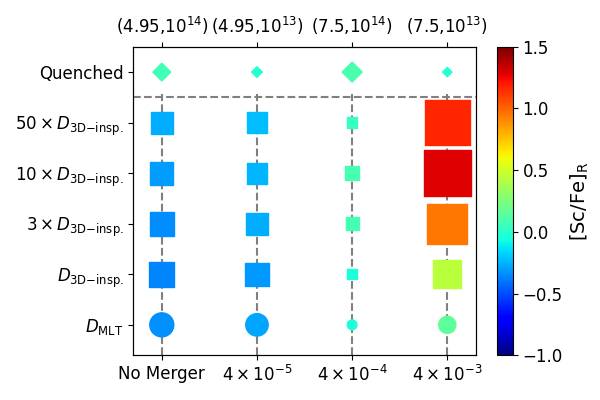

In [22]:
result = comps
cbarlabel = rf"$[\mathrm{{{ele_of_interest}}}/\mathrm{{Fe}}]_{{\mathrm{{R}}}}$"
#cbarlabel = r"$\log_{10}(\mathrm{{{^{40}K}}})$"


#result = np.log10(result)

ifig=2;plt.close(ifig);
fig,ax=plt.subplots(num=ifig, figsize=(6,4))

min_scale, max_scale = -1, 1.5

ax.scatter(xs_full[:4], ys_full[:4], c=get_color(result[:4], min_scale, max_scale), \
                 s=scale_size(result[:4], min_scale, max_scale, min_size=20, max_size=1300, centre=0), zorder=10)

ax.scatter(xs_full[4:20], ys_full[4:20], c=get_color(result[4:20], min_scale, max_scale), marker='s', \
                 s=scale_size(result[4:20], min_scale, max_scale, min_size=20, max_size=1300, centre=0), zorder=10)

ax2 = plt.twiny()

ax2.scatter(xs_full[20:], ys_full[20:], c=get_color(result[20:], min_scale, max_scale), marker='D', \
                 s=scale_size(result[20:], min_scale, max_scale, min_size=20, max_size=1300, centre=0), zorder=10)

ax2.axhline(4.5, color="grey", linestyle='--')

norm, cmap = get_color(0, min_scale, max_scale, get='map')
sm = ScalarMappable(norm=norm, cmap='jet')
sm.set_array([])
cbar = plt.colorbar(sm)
#cbar.set_ticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=12)  # Set tick label font size
cbar.set_label(cbarlabel, fontsize=14)  # Label font size

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels=['No Merger', r'$4\times10^{-5}$',r'$4\times10^{-4}$',r'$4\times10^{-3}$'], fontsize=12)

ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(labels=[r'$D_{\mathrm{MLT}}$',r"$D_{\mathrm{3D{-}insp.}}$",r"$3\times D_{\mathrm{3D{-}insp.}}$",r"$10\times D_{\mathrm{3D{-}insp.}}$",r"$50\times D_{\mathrm{3D{-}insp.}}$", "Quenched"], fontsize=12)

for i in range(4):
    ax.axvline(i, ymin=0,ymax=4.23/5, color='grey', linestyle='--')


ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(labels=[r"(4.95,$10^{14}$)", r"(4.95,$10^{13}$)", r"(7.5,$10^{14}$)", r"(7.5,$10^{13}$)"], fontsize=12)


ax.set_xlim(-0.3,3.3)
ax2.set_xlim(-0.3,3.3)
ax2.set_ylim(-0.6,5.5)
plt.tight_layout()

#plt.savefig(f"../figures/ratio_{ele_of_interest.lower()}.pdf")

In [23]:
def get_element(elements, case, ing):
        
    X_issa = results[case][ing]
        
        
    comparisons = np.zeros(len(elements))
        
    for q, element in enumerate(elements):

        ele_solar = ini.ele[element].abu_solar
        fe_solar  = ini.ele["Fe"].abu_solar


        ele_idx = (el_name[1:-1]).index(element)

        fe_idx = (el_name[1:-1]).index("Fe")

        comparison = np.log10(X_issa[ele_idx] / X_issa[fe_idx]) - np.log10(ele_solar / fe_solar)

        comparisons[q] = comparison

    return comparisons

In [24]:
def get_ritter(elements):
    eles = star.se.isos[1:-2]
    
    comparisons = np.zeros(len(elements))
    
    for q, element in enumerate(elements):
        ele_solar = ini.ele[element].abu_solar
        fe_solar  = ini.ele["Fe"].abu_solar

        ele_idx = eles.index(element)
        fe_idx  = eles.index("Fe")
        
        comparison = np.log10(X_nugrid[ele_idx] / X_nugrid[fe_idx]) - np.log10(ele_solar / fe_solar)
        
        comparisons[q] = comparison
        
    return comparisons

In [25]:
elemental_breakdown = {}

elements = ["C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn"]

for case in list(results.keys()):
    
    elemental_breakdown[case] = {}
    
    for ing in list(results[case].keys()):
        
        elemental_breakdown[case][ing] = get_element(elements, case, ing)

In [26]:
elemental_breakdown["PPM50"]["7.95E+03"]

array([ 0.64435514,  0.63132613,  1.3230188 , -0.08083142,  0.32494544,
        0.48910926,  0.49912213,  0.45408579,  0.75404134,  1.90838806,
        1.46145654,  2.65535406,  1.98535459,  3.07488644,  1.69189318,
        2.96902387,  1.27220832,  1.07513473,  0.02444544, -0.09799522])

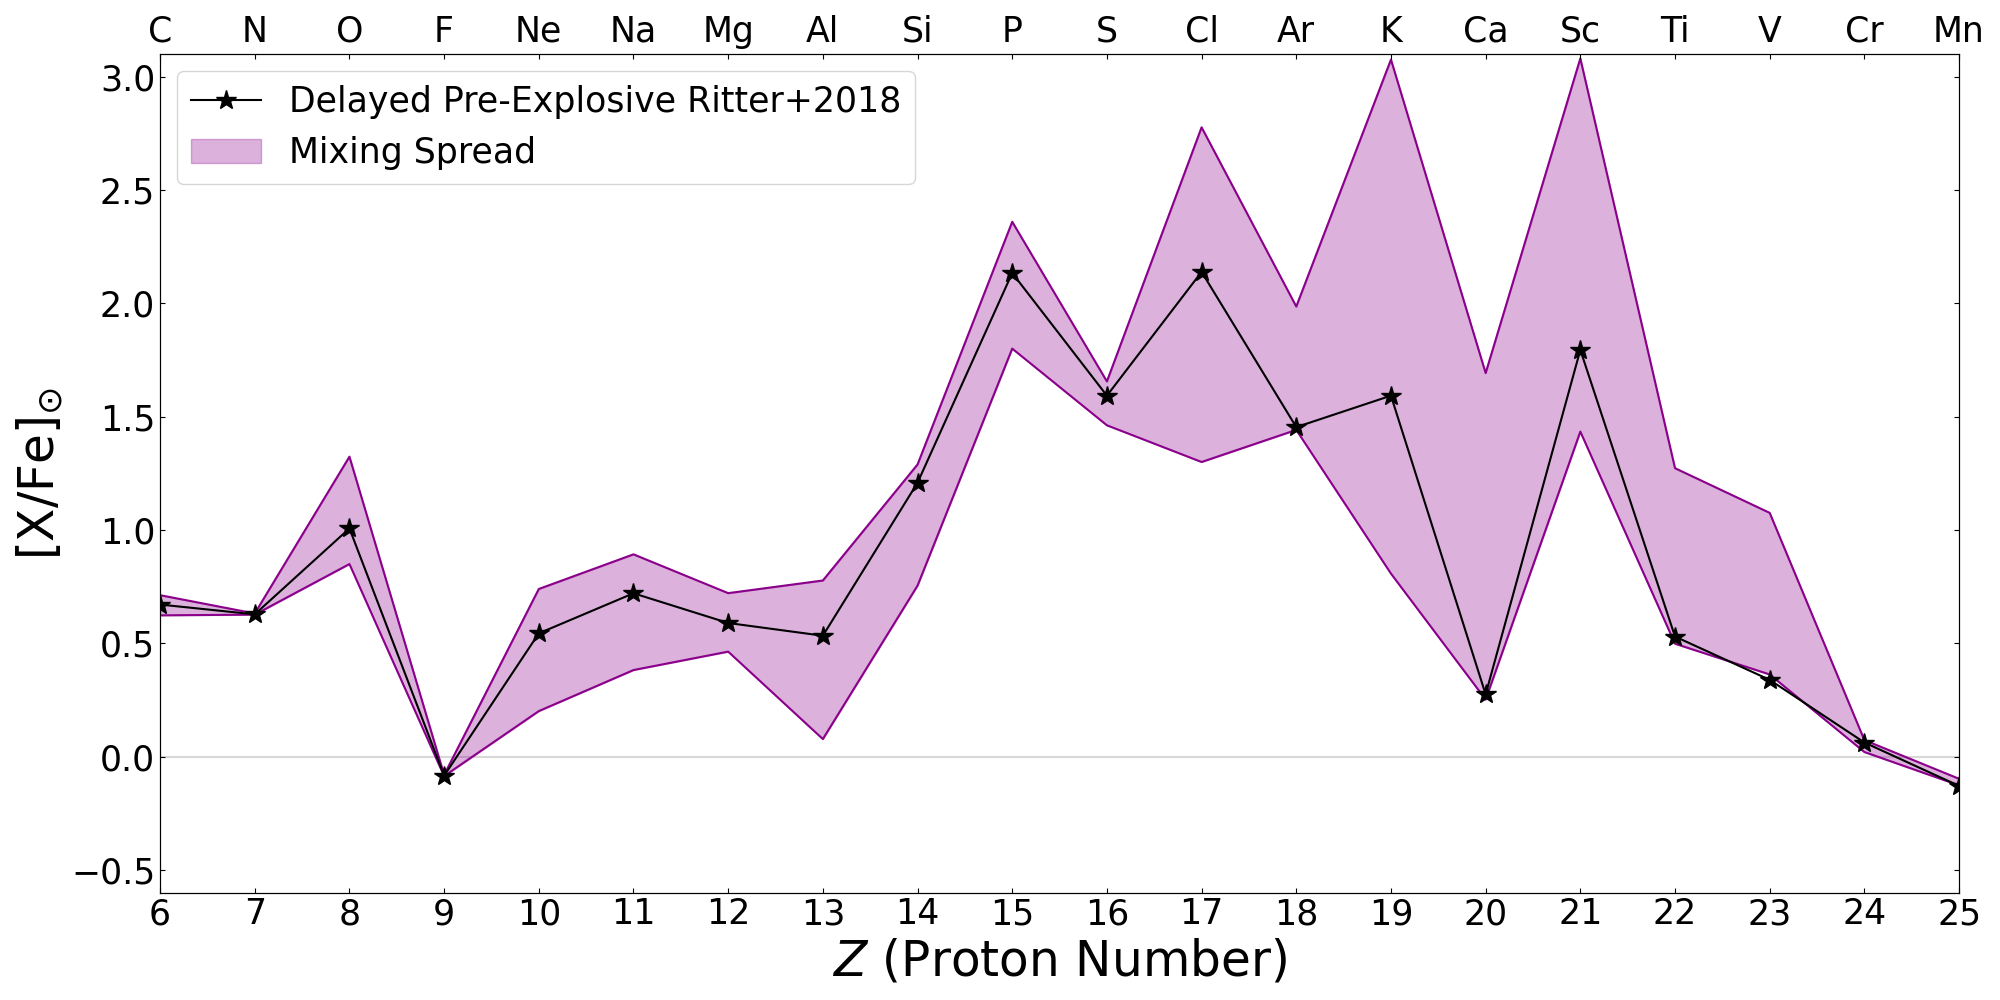

In [248]:
ifig=3;plt.close(ifig);plt.figure(ifig, figsize=(20,10))

Zs = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

small, big = 100*np.ones(len(elements)), -100*np.ones(len(elements))

for case in results:
    for ing in results[case]:
        y = np.array(elemental_breakdown[case][ing])
        
        small[y < small] = y[y < small]
        big[y > big] = y[y > big]

plt.plot(Zs, small, zorder=3, color='darkmagenta')
plt.plot(Zs, big, zorder=3, color='darkmagenta')        
plt.fill_between(Zs, small, big, alpha=0.3, zorder=2, color='darkmagenta', label='Mixing Spread') 

plt.plot(Zs, get_ritter(elements), zorder=4, color='black', marker='*', markersize=15, label='Delayed Pre-Explosive Ritter+2018')

plt.axhline(0, color='grey', alpha=0.3, zorder=1)

plt.xlim(6,25)

plt.xticks(range(6,26))
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in', left=True, right=True)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.ylim(-0.6,3.1)

plt.xlabel(r"$Z$ (Proton Number)", fontsize=35)
plt.ylabel(r"$[\mathrm{{X}}/\mathrm{{Fe}}]_{{\mathrm{{\odot}}}}$", fontsize=35)


plt.legend(loc='upper left', fancybox=True, fontsize=25)

ax2 = plt.twiny()

ax2.set_xticks(Zs)
ax2.set_xticklabels(elements, fontsize=25)
ax2.tick_params(axis='x', direction='in')

ax2.set_xlim(6,25)

plt.tight_layout()

#plt.savefig("../figures/elemental_impact.pdf")

###### 

## Isotopic ?

In [11]:
el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need("MLT", "7.95E+03")
    

This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


In [12]:
surfisotopes = surf.se.isotopes
surface_isotopes_decayed = np.vstack(surf.get('iso_massf_decay'))
EMwind_decay_isos = np.zeros(surface_isotopes_decayed.shape[1])

for i in range(surface_isotopes_decayed.shape[1]):
    EMwind_decay_isos[i] = np.trapz(np.abs(Mdot) * surface_isotopes_decayed[:-2,i], star_age)

 reading ['iso_massf_decay']...100%

In [13]:
star.get_abundance_iso_decay(9200)

decayed_isos_9200 = np.vstack(star.decayed_stable_isotopes_per_cycle)

 reading ['mass']...100%Using The following conditions:
	mass_range: 3.8433534134926377e-07 12.15340998801299
	cycle: 9200
 reading ['iso_massf']...100%WARNING:
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


In [14]:
star.get_abundance_iso_decay(21000)

decayed_isos_21000 = np.vstack(star.decayed_stable_isotopes_per_cycle)

 reading ['mass']...100%Using The following conditions:
	mass_range: 3.8433032128025213e-07 12.15340998801299
	cycle: 21000
 reading ['iso_massf']...100%WARNING:
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


In [15]:
ri_mass_9200 = star.get(9200, "mass")
ri_mass_21000 = star.get(21000, "mass")

 reading ['mass']...100%

In [16]:
def format_isotope(entry):
    try:
        parts = entry.split()
        symbol = parts[0].capitalize() if len(parts[0]) == 1 else parts[0][0].upper() + parts[0][1:].lower()
        mass = parts[1]
    except:
        parts = [entry[:2], entry[2:]]
        symbol = parts[0].capitalize() if len(parts[0]) == 1 else parts[0][0].upper() + parts[0][1:].lower()
        mass = parts[1]
    return f"{symbol}-{mass}"

isos = [format_isotope(x) for x in star.stable_isotope_list]

In [17]:
def getyields_isos():
        
        
    def get_idx(thing, what):
        
        return np.argmin(np.abs(thing-what))
    
    
    delay, rapid = get_idx(ri_mass_21000, 1.61), get_idx(ri_mass_21000, 1.44)
        
        
    # this is only SN yields... I need wind yields too...
        
        
    delayMej = ri_mass_21000[-1] - ri_mass_21000[delay]
    rapidMej = ri_mass_21000[-1] - ri_mass_21000[rapid]
        
    delayedEM = np.zeros(len(isos))
    rapidEM = np.zeros(len(isos))
        
    for i in range(len(isos)):
        
        delayedEM[i] = np.trapz(decayed_isos_21000[delay:,i] , ri_mass_21000[delay:])

        rapidEM[i]   = np.trapz(decayed_isos_21000[rapid:,i] , ri_mass_21000[rapid:])
        
    return delayedEM, rapidEM, delayMej, rapidMej
    
delayedEMiso, rapidEMiso, delayMejiso, rapidMejiso = getyields_isos()

In [18]:
def calculate_full_yields_isos(mixing_case, sub_case):
    
    el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need(mixing_case, sub_case)
        
    def get_idx(thing, what):
        
        return np.argmin(np.abs(thing-what))
    
    
    def get_ratios():
        
        left = 1.5510275
        right = 1.9983082

        lidx = np.argmin(np.abs(ri_mass_9200 - left))
        ridx = np.argmin(np.abs(ri_mass_9200 - right))
        
        ratios = []
        
        for iso in isos:

            me_i = iso_name.index(iso)
            ri_i = isos.index(iso)
            
            mOshell = ri_mass_9200[ridx] - ri_mass_9200[lidx]

            X_av_ri = np.trapz( decayed_isos_9200[lidx:ridx, ri_i], ri_mass_9200[lidx:ridx] ) / mOshell

            X_surf_me = iso_abu_0[me_i]

            ratios.append(X_surf_me/X_av_ri)

        return ratios
    
    
    ratios = get_ratios()    
        
    #q, j,k,l = get_idx(ri_mass_21000,1.44), get_idx(ri_mass_21000,1.5510275), get_idx(ri_mass_21000,2.95), -1
    
    j, k, l = get_idx(ri_mass_21000,1.61), get_idx(ri_mass_21000,2.95), -1
    
    X_nugrid = []
    X_issa = []
    
    for iso in isos:
    
        ri_i = isos.index(iso)
        
        surf_i = surfisotopes.index(iso)
        
        ratio_idx = isos.index(iso)
        ratio = ratios[ratio_idx]
        
        #X_av_under = np.trapz( decayed_elements_21000[q:j, ri_i] , ri_mass_21000[q:j])
        X_av_oc = np.trapz( decayed_isos_21000[j:k, ri_i] * ratio , ri_mass_21000[j:k])
        X_av_above = np.trapz( decayed_isos_21000[k:l, ri_i], ri_mass_21000[k:l])
        
        #X_issa.append( (X_av_under + X_av_oc + X_av_above) + EMwind_decay[1:-1][ri_i] )
        X_issa.append( (X_av_oc + X_av_above)  + EMwind_decay_isos[surf_i] )
                
        X_nugrid.append( np.trapz( decayed_isos_21000[j:l, ri_i], ri_mass_21000[j:l] + EMwind_decay_isos[surf_i] ) )

    # renormalize such that np.sum(X) = 1
        
    X_nugrid = np.array(X_nugrid)
    
    #print(f"\nI have to renormalize X(NuGrid) because it sums to {round(np.sum(X_nugrid),3)}.")
    
    X_nugrid = X_nugrid / np.sum(X_nugrid)
    
    
    X_issa = np.array(X_issa)
    
    #print(f"I have to renormalize X(Issa) because it sums to {round(np.sum(X_nugrid),3)}.")

    X_issa[~np.isfinite(X_issa)] = 1e-99
        
    X_issa = X_issa / np.sum(X_issa)

    return X_nugrid, X_issa

In [19]:
results_isos = {}


for case in ["MLT", "PPM", "PPM3", "PPM10", "PPM50"]:
    results_isos[case] = {}
    print(case)
    for ing in ["0.00E+00","7.95E+01","7.95E+02","7.95E+03"]:
        print(f'\t{ing}')
        with suppress_stdout():
            X_nugrid_isos, X_issa_isos = calculate_full_yields_isos(case, ing)
            results_isos[case][ing] = X_issa_isos
        
results_isos["GOSH"] = {}
print('GOSH')
for ing in ["gosh", "gosh_stronger", "partial_merger", "partial_merger_stronger"]:
    print(f'\t{ing}')
    with suppress_stdout():
        X_nugrid_isos, X_issa_isos = calculate_full_yields_isos("GOSH", ing)

        results_isos["GOSH"][ing] = X_issa_isos

MLT
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM3
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM10
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
PPM50
	0.00E+00
	7.95E+01
	7.95E+02
	7.95E+03
GOSH
	gosh
	gosh_stronger
	partial_merger
	partial_merger_stronger


In [20]:
k39, k40, k41 = isos.index('K-39'), isos.index('K-40'), isos.index('K-41')

In [21]:
sc, ing = '', ''
maxxx = 10

looking_for = k40

for key in results_isos.keys():
    for key2 in results_isos[key].keys():
        
        res = results_isos[key][key2][looking_for]
        
        if res < maxxx:
            
            sc, ing = key, key2
            
            maxxx = res

In [22]:
sc, ing, maxxx

('PPM', '0.00E+00', 3.777450251566759e-07)

In [23]:
mass_lost = np.sum(EMwind_decay_isos) + np.sum(delayedEMiso)

In [190]:
print(f"{mass_lost*results_isos['PPM10']['7.95E+03'][k39]:.3e}",
      f"{mass_lost*results_isos['PPM10']['7.95E+03'][k40]:.3e}",
      f"{mass_lost*results_isos['PPM10']['7.95E+03'][k41]:.3e}")

3.992e-02 3.054e-03 9.857e-04


In [25]:
sc, ing, maxxx

('PPM', '0.00E+00', 3.777450251566759e-07)

In [189]:
print(f"{mass_lost*results_isos['PPM']['0.00E+00'][k39]:.3e}",
      f"{mass_lost*results_isos['PPM']['0.00E+00'][k40]:.3e}",
      f"{mass_lost*results_isos['PPM']['0.00E+00'][k41]:.3e}")

3.434e-04 5.055e-06 2.101e-05


In [240]:
isotope = 'K-40'
element = 'Fe'

xs_full, ys_full = [], []

comps = []

i, j = 0, 0
eles = star.se.isos[1:-2]
for case in list(results.keys()):
    
    for ing in list(results[case].keys()):
        
        X_issa = results[case][ing]
        X_issa_iso = results_isos[case][ing]
                                
        iso_idx = (isos).index(isotope)
        
        ele_idx = (el_name[1:-1]).index(element)
        
        iso_nug = (isos).index(isotope)
        ele_nug = (eles).index(element)
        
        comparison = np.log10(X_issa_iso[iso_idx] / X_issa[ele_idx]) - np.log10(X_nugrid_isos[iso_nug] / X_nugrid[ele_nug])
                            
        comps.append(comparison)
                        
        xs_full.append(i)
        ys_full.append(j)
        
        

        i += 1
        
        if i == 4: 
            i = 0
            j += 1
        
comps = np.array(comps)

round(np.min(comps), 4), round(np.max(comps), 4), round(np.median(comps), 4)

(-1.5143, 1.3106, -0.6271)

In [235]:
iso_solar = ini.iso[isotope].abu_solar
ele_solar = ini.ele[element].abu_solar
        
np.log10(X_nugrid_isos[iso_nug] / X_nugrid[ele_nug]) - np.log10(iso_solar/ele_solar)

1.6460670536763753

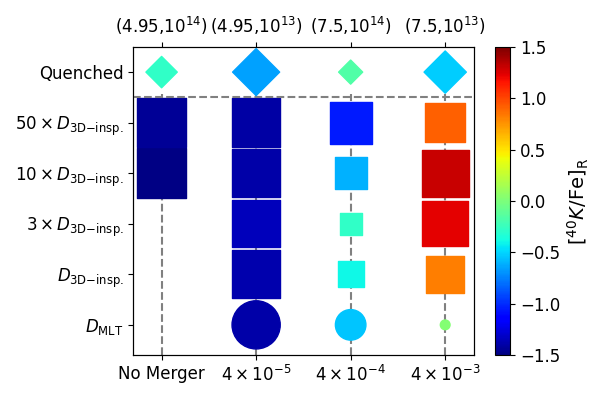

In [242]:
result = comps
cbarlabel = rf"$[{{{format_(isotope)}}}/\mathrm{{{element}}}]_{{\mathrm{{R}}}}$"
#cbarlabel = r"$\log_{10}(\mathrm{{{^{40}K}}})$"


#result = np.log10(result)

ifig=2;plt.close(ifig);
fig,ax=plt.subplots(num=ifig, figsize=(6,4))

min_scale, max_scale = -1.5, 1.5

ax.scatter(xs_full[:4], ys_full[:4], c=get_color(result[:4], min_scale, max_scale), \
                 s=scale_size(result[:4], min_scale, max_scale, min_size=20, max_size=1300, centre=0), zorder=10)

ax.scatter(xs_full[4:20], ys_full[4:20], c=get_color(result[4:20], min_scale, max_scale), marker='s', \
                 s=scale_size(result[4:20], min_scale, max_scale, min_size=20, max_size=1300, centre=0), zorder=10)

ax2 = plt.twiny()

ax2.scatter(xs_full[20:], ys_full[20:], c=get_color(result[20:], min_scale, max_scale), marker='D', \
                 s=scale_size(result[20:], min_scale, max_scale, min_size=20, max_size=1300, centre=0), zorder=10)

ax2.axhline(4.5, color="grey", linestyle='--')

norm, cmap = get_color(0, min_scale, max_scale, get='map')
sm = ScalarMappable(norm=norm, cmap='jet')
sm.set_array([])
cbar = plt.colorbar(sm)
#cbar.set_ticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=12)  # Set tick label font size
cbar.set_label(cbarlabel, fontsize=14)  # Label font size

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels=['No Merger', r'$4\times10^{-5}$',r'$4\times10^{-4}$',r'$4\times10^{-3}$'], fontsize=12)

ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(labels=[r'$D_{\mathrm{MLT}}$',r"$D_{\mathrm{3D{-}insp.}}$",r"$3\times D_{\mathrm{3D{-}insp.}}$",r"$10\times D_{\mathrm{3D{-}insp.}}$",r"$50\times D_{\mathrm{3D{-}insp.}}$", "Quenched"], fontsize=12)

for i in range(4):
    ax.axvline(i, ymin=0,ymax=4.23/5, color='grey', linestyle='--')


ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(labels=[r"(4.95,$10^{14}$)", r"(4.95,$10^{13}$)", r"(7.5,$10^{14}$)", r"(7.5,$10^{13}$)"], fontsize=12)


ax.set_xlim(-0.3,3.3)
ax2.set_xlim(-0.3,3.3)
ax2.set_ylim(-0.6,5.5)
plt.tight_layout()

plt.savefig(f"../figures/k40_k.pdf")